In [1]:
from matplotlib import pyplot as plt
from parselog import *
import itertools
import multiprocessing
import numpy as np
import os
import pickle
import sys

In [2]:
PREFETCHERS = [
    "all_in_cap",
    "cap_spatial",
    "cap_ptr",
    "cap_spatial_ptr",
    "cheri_stride",
    "stride",
    "stride_adaptive",
]

In [3]:
LOCATIONS = ["l1", "l1ll"]

In [4]:
BENCHMARKS = [
    "adpcm_decode",
    "adpcm_encode",
    "aes",
    "basicmath",
    "blowfish",
    "crc",
    "dijkstra",
    "fft",
    "picojpeg",
    "qsort",
    "rc4",
]

In [11]:
def statL1AccessFrequency(lp):
    return lp.totals[CRqCreationLine]["demand"]/lp.totals[RVFILine]["total"]

def statL1DemandHitRate(lp):
    return lp.totals[CRqCreationLine]["demandHit"]/lp.totals[CRqCreationLine]["demand"]

def statL1DemandMissRate(lp):
    return lp.totals[CRqCreationLine]["demandMiss"]/lp.totals[CRqCreationLine]["demand"]

def statL1PrefetchFrequency(lp):
    return lp.totals[CRqCreationLine]["prefetch"]/lp.totals[RVFILine]["total"]

def statL1PrefetchCreation(lp):
    return lp.totals[CRqCreationLine]["prefetch"]

def statL1PrefetchHitRate(lp):
    if lp.totals[CRqCreationLine]["prefetch"]:
        return lp.totals[CRqCreationLine]["prefetchHit"]/lp.totals[CRqCreationLine]["prefetch"]
    else:
        return 0
    
def statL1PrefetchMissRate(lp):
    if lp.totals[CRqCreationLine]["prefetch"]:
        return lp.totals[CRqCreationLine]["prefetchMiss"]/lp.totals[CRqCreationLine]["prefetch"]
    else:
        return 0
    
def statL1PrefetchAccuracy(lp):
    if lp.totals[CRqCreationLine]["prefetchMiss"]:
        return (lp.totals[CRqCreationLine]["prefetchMiss"]-lp.totals[CRqCreationLine]["uselessPrefetch"])/lp.totals[CRqCreationLine]["prefetchMiss"]
    else:
        return 0
    
def statL1LatePrefetchCreationFrequency(lp):
    denom = lp.totals[CRqCreationLine]["prefetchHit"] + lp.totals[CRqCreationLine]["prefetchOwned"]
    if denom:
        return lp.totals[CRqCreationLine]["latePrefetchCreation"]/denom
    else:
        return 0
    
def statL1LatePrefetchIssueFrequency(lp):
    denom = lp.totals[CRqCreationLine]["prefetchMiss"]
    if denom:
        return lp.totals[CRqCreationLine]["latePrefetchIssue"]/lp.totals[CRqCreationLine]["prefetchMiss"]
    else:
        return 0
    
def statILP(lp):
    for ll in reversed(lp.logLines):
        if isinstance(ll, RVFILine):
            return ll.rvfi/ll.timestamp
        
def statL1LineContainsPointersFrequency(lp):
    return sum(x > 0 for x in lp.dists[CRqHitLine]["missNCap"]) / lp.totals[CRqMissLine]["total"]

def statL1AllInCapTriggerFrequency(lp):
    return sum(x <= 256 for x in lp.dists[CRqCreationLine]["demandCapSize"]) / lp.totals[CRqCreationLine]["demand"]

def statL1CapSpatialFrequency(lp):
    return sum(x <= 32768 for x in lp.dists[CRqCreationLine]["demandCapSize"]) / lp.totals[CRqCreationLine]["demand"]

def statL1CapPtrFrequency(lp):
    return sum(x <= 2097152 for x in lp.dists[CRqCreationLine]["demandCapSize"]) / lp.totals[CRqCreationLine]["demand"]

def statL1CapSpatialPtrFrequency(lp):
    return sum(x <= 1048576 for x in lp.dists[CRqCreationLine]["demandCapSize"]) / lp.totals[CRqCreationLine]["demand"]

def statL1PrefetchDisruption(lp):
    if lp.totals[CRqCreationLine]["prefetchMiss"]:
        return lp.totals[CRqCreationLine]["prefetchDisruption"]/lp.totals[CRqCreationLine]["prefetchMiss"]
    else:
        return 0

def statL1UselessPrefetchDisruption(lp):
    if lp.totals[CRqCreationLine]["prefetchMiss"]:
        return lp.totals[CRqCreationLine]["uselessPrefetchDisruption"]/lp.totals[CRqCreationLine]["prefetchMiss"]
    else:
        return 0

statFuncs = {
    "Speedup"                                       : (lambda x: None),                   
    "ILP"                                           : statILP,                            
    "L1 Access Frequency"                           : statL1AccessFrequency,              
    "L1 Demand Hit Rate"                            : statL1DemandHitRate,                
    "L1 Demand Miss Rate"                           : statL1DemandMissRate,               
    "L1 Prefetch Frequency"                         : statL1PrefetchFrequency,            
    "L1 Prefetch Creation"                          : statL1PrefetchCreation,             
    "L1 Prefetch Hit Rate"                          : statL1PrefetchHitRate,              
    "L1 Prefetch Miss Rate"                         : statL1PrefetchMissRate,             
    "L1 Prefetcher Accuracy"                        : statL1PrefetchAccuracy,             
    "L1 Prefetcher Coverage"                        : (lambda x: None),                   
    "L1 Late Prefetch Creation Frequency"           : statL1LatePrefetchCreationFrequency,
    "L1 Late Prefetch Issue Frequency"              : statL1LatePrefetchIssueFrequency,   
    "L1 New Line Contains Pointers Frequency"       : statL1LineContainsPointersFrequency,
    "L1 AllInCap Trigger Frequency (256)"           : statL1AllInCapTriggerFrequency,     
    "L1 CapSpatial Trigger Frequency (32768)"        : statL1CapSpatialFrequency,          
    "L1 CapPtr Trigger Frequency (2097152)"         : statL1CapPtrFrequency,              
    "L1 CapSpatialPtr Trigger Frequency (1048576)"  : statL1CapSpatialPtrFrequency,       
    "L1 Prefetch Disruption Frequency"              : statL1PrefetchDisruption,    
    "L1 Uselss Prefetch Disruption Frequency"       : statL1UselessPrefetchDisruption,    
}

noPrefetcherRequiredForStat = [
    "L1 Access Frequency",
    "L1 New Line Contains Pointers Frequency",
    "L1 AllInCap Trigger Frequency (256)",
    "L1 CapSpatial Trigger Frequency (32768)",
    "L1 CapPtr Trigger Frequency (2097152)",
    "L1 CapSpatialPtr Trigger Frequency (1048576)",
]

noBaselineRequiredForStat = [
    "Speedup",
    "L1 Prefetch Frequency",
    "L1 Prefetch Creation",
    "L1 Prefetch Hit Rate",
    "L1 Prefetch Miss Rate",
    "L1 Prefetcher Accuracy",
    "L1 Prefetcher Coverage",
    "L1 Late Prefetch Creation Frequency",
    "L1 Late Prefetch Issue Frequency",
]

In [6]:

def loadPrefetcherData(run, prefetcher, location, benchmark):
    stats = {}
    logPath = f"results/{run}-{prefetcher}-{location}/{benchmark}/sim_stdout.gz"
    lp = None
    if os.path.isfile(logPath):
        sys.stdout.write(f"Loading {run}-{prefetcher}-{location}/{benchmark}...\n")
        sys.stdout.flush()
        oldStdout = sys.stdout
        with open(os.devnull, "w") as sys.stdout:
            lp = LogParser(
                log=logPath, 
                lineTypesToPrune=[None, NonRVFILine],
                lineTypesToError=[TimestampedLine],
                RootLogLine=TimestampedLine,
                startWhen=(lambda ll: isinstance(ll, RVFILine) and ll.rvfi >= 10000),
            );
        sys.stdout = oldStdout
        sys.stdout.write(f"... loaded {run}-{prefetcher}-{location}/{benchmark}\n")
        sys.stdout.flush()
    for statName, statFunc in statFuncs.items():
        stats[statName] = statFunc(lp) if lp else 0
    return run, prefetcher, location, benchmark, stats

def mute():
    sys.stdout = open(os.devnull, 'w') 

def loadPrefetcherDataWrapper(args):
    return loadPrefetcherData(*args)

globalStats = {}
if os.path.isfile("results/globalStats.pickle"):
    print("Loading from pickle...")
    with open("results/globalStats.pickle", "rb") as fp:
        globalStats = pickle.load(fp)
    print("... finished loading from pickle")
else:
    globalStats = {}
    pool = None
    with multiprocessing.Pool(processes=48) as pool:

        none_tuples = [("all2", "none", "none", benchmark) for benchmark in BENCHMARKS]
        some_tuples = itertools.product(["all2"], PREFETCHERS, LOCATIONS, BENCHMARKS)
        all_tuples = [*none_tuples, *some_tuples]

        results = pool.map(loadPrefetcherDataWrapper, all_tuples)

        for run, prefetcher, location, benchmark, stats in results:
            for statName, statValue in stats.items():
                if not run in globalStats:
                    globalStats[run] = {}
                if not statName in globalStats[run]:
                    globalStats[run][statName] = {}
                if not prefetcher in globalStats[run][statName]:
                    globalStats[run][statName][prefetcher] = {}
                if not location in globalStats[run][statName][prefetcher]:
                    globalStats[run][statName][prefetcher][location] = []            
                globalStats[run][statName][prefetcher][location].append(statValue)

        for run, prefetcher, location, benchmark in all_tuples:
            for i in range(len(BENCHMARKS)):
                globalStats[run]["Speedup"][prefetcher][location][i] = (
                    globalStats[run]["ILP"][prefetcher][location][i] / 
                    globalStats[run]["ILP"]["none"]["none"][i]
                ) - 1
                globalStats[run]["L1 Prefetcher Coverage"][prefetcher][location][i] = 1 - (
                    globalStats[run]["L1 Demand Miss Rate"][prefetcher][location][i] /
                    globalStats[run]["L1 Demand Miss Rate"]["none"]["none"][i]
                )

    with open("results/globalStats.pickle", "wb") as fp:
        pickle.dump(globalStats, fp)


Loading all2-none-none/adpcm_decode...
Loading all2-none-none/adpcm_encode...
Loading all2-none-none/aes...
Loading all2-none-none/basicmath...
Loading all2-none-none/blowfish...
Loading all2-none-none/crc...
Loading all2-none-none/dijkstra...
Loading all2-none-none/fft...
Loading all2-none-none/qsort...
Loading all2-none-none/picojpeg...
Loading all2-none-none/rc4...
Loading all2-all_in_cap-l1/adpcm_encode...
Loading all2-all_in_cap-l1/adpcm_decode...
Loading all2-all_in_cap-l1/aes...
Loading all2-all_in_cap-l1/blowfish...
Loading all2-all_in_cap-l1/crc...
Loading all2-all_in_cap-l1/fft...
Loading all2-all_in_cap-l1/basicmath...
Loading all2-all_in_cap-l1/picojpeg...
Loading all2-all_in_cap-l1/dijkstra...
Loading all2-cap_spatial-l1/adpcm_decode...
Loading all2-all_in_cap-l1/qsort...
Loading all2-all_in_cap-l1/rc4...
Loading all2-cap_spatial-l1/aes...
Loading all2-cap_spatial-l1/adpcm_encode...
Loading all2-cap_spatial-l1/crc...
Loading all2-cap_spatial-l1/dijkstra...
Loading all2-cap

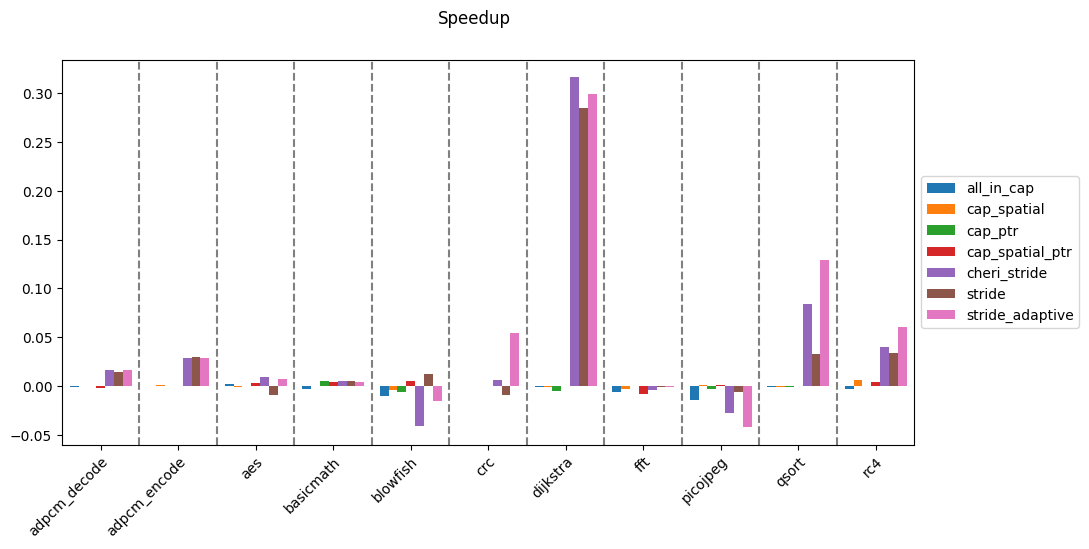

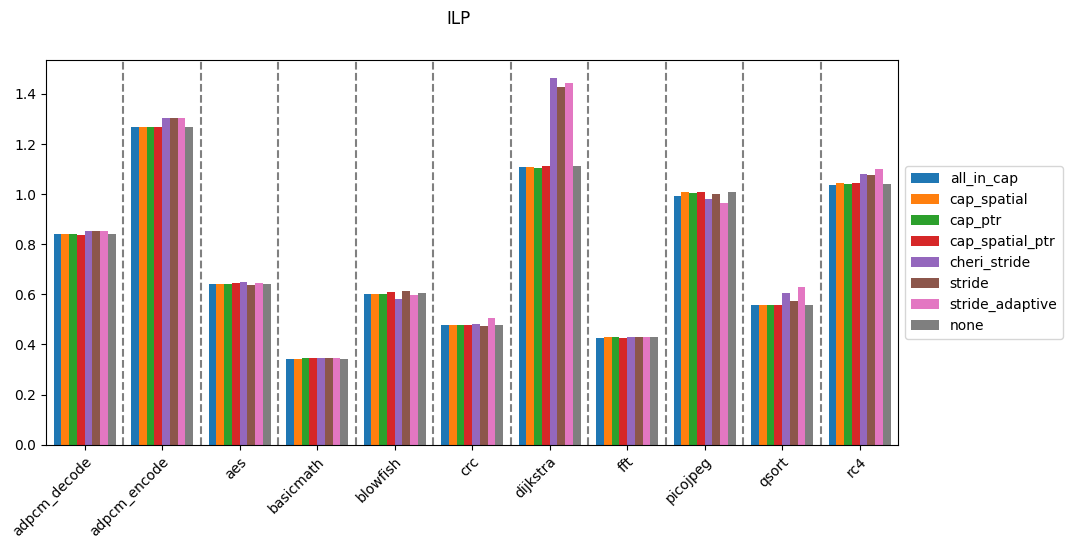

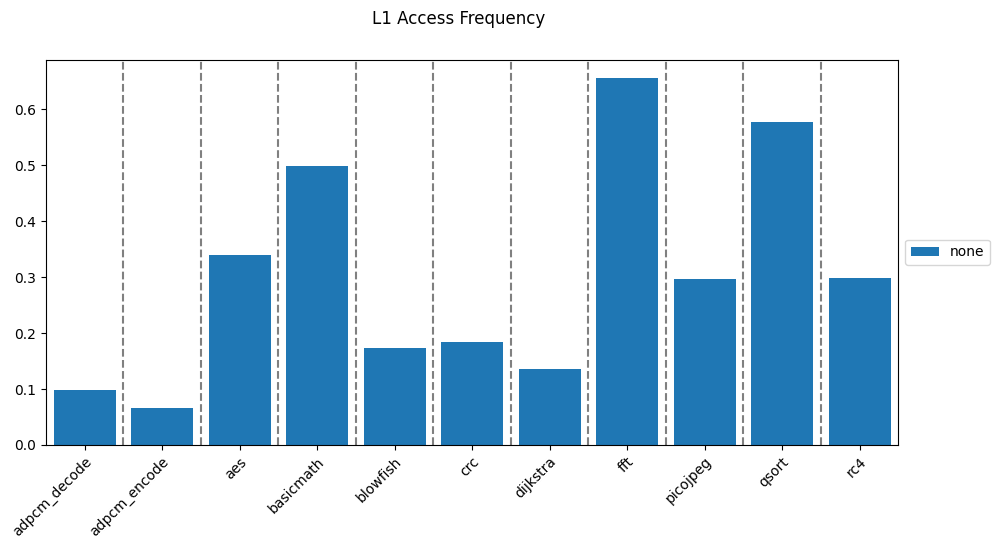

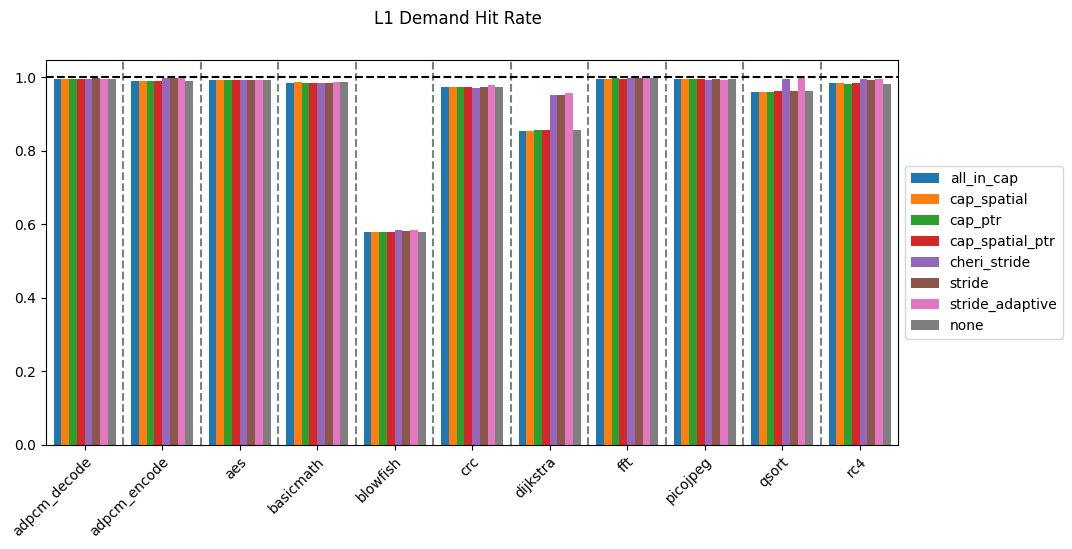

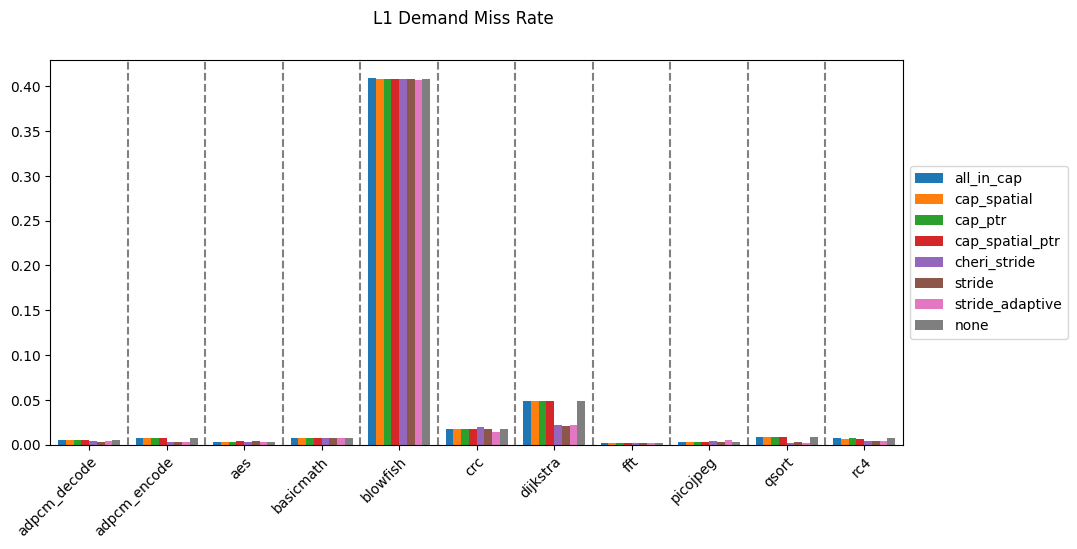

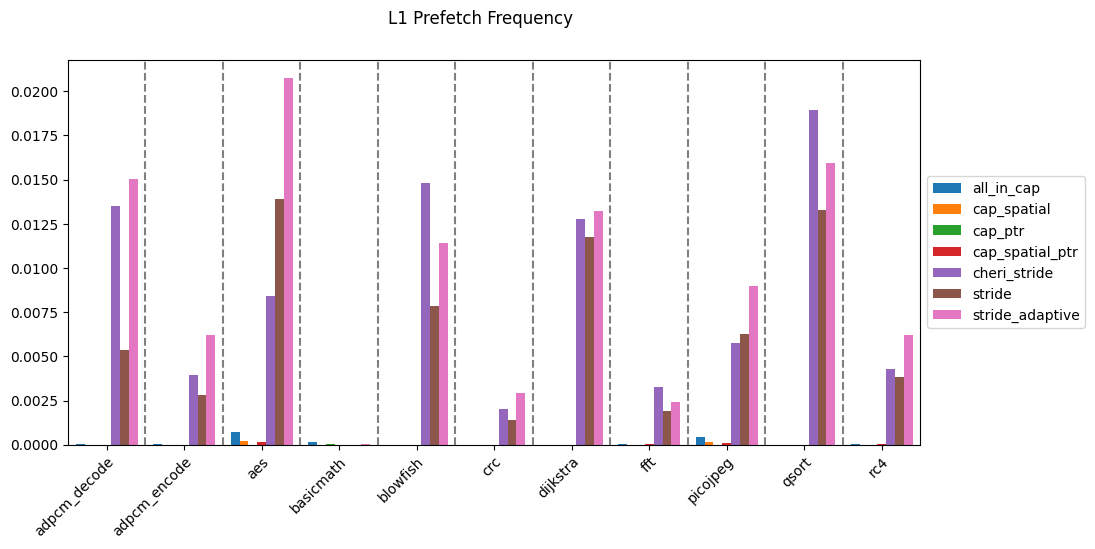

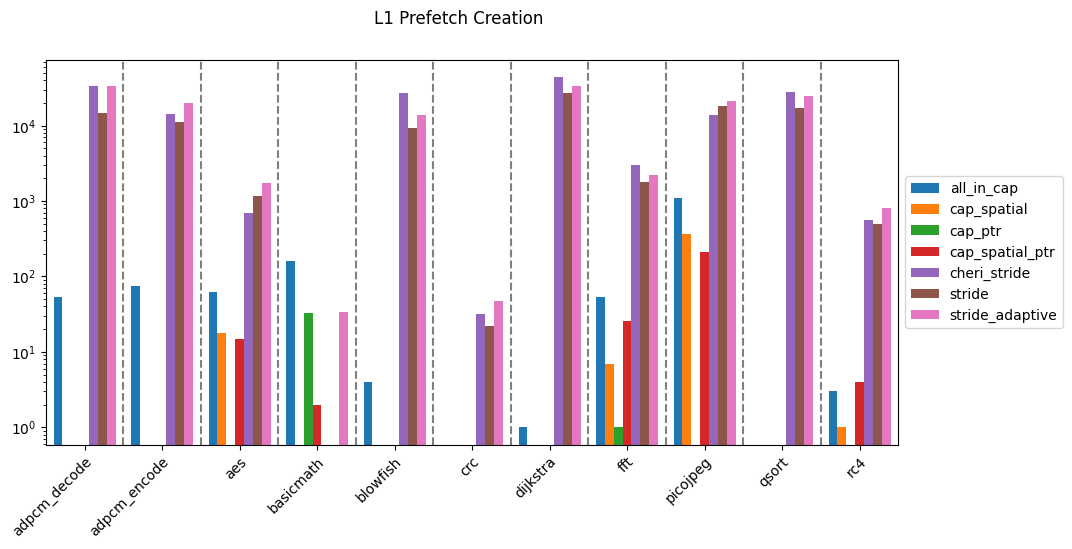

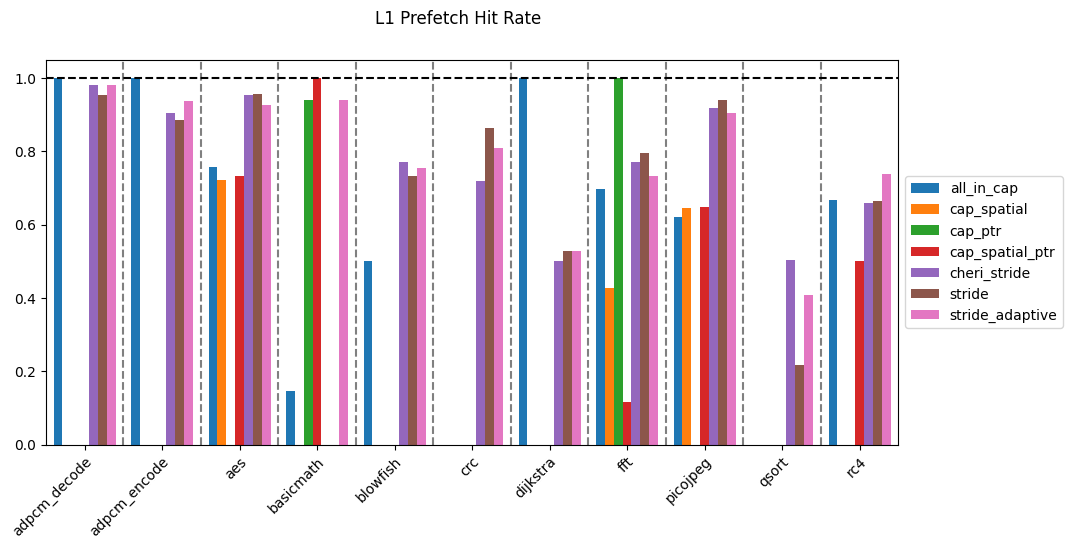

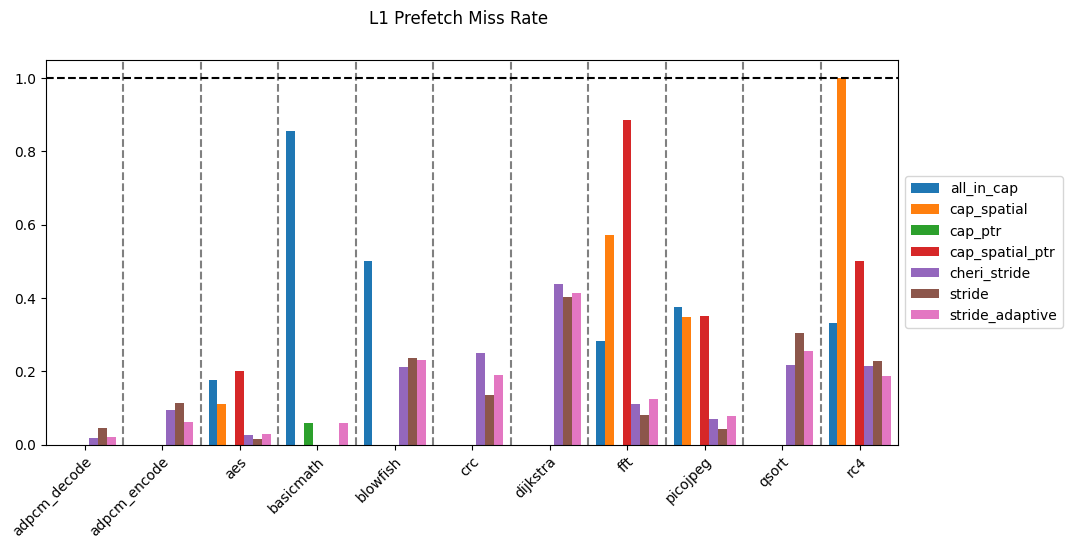

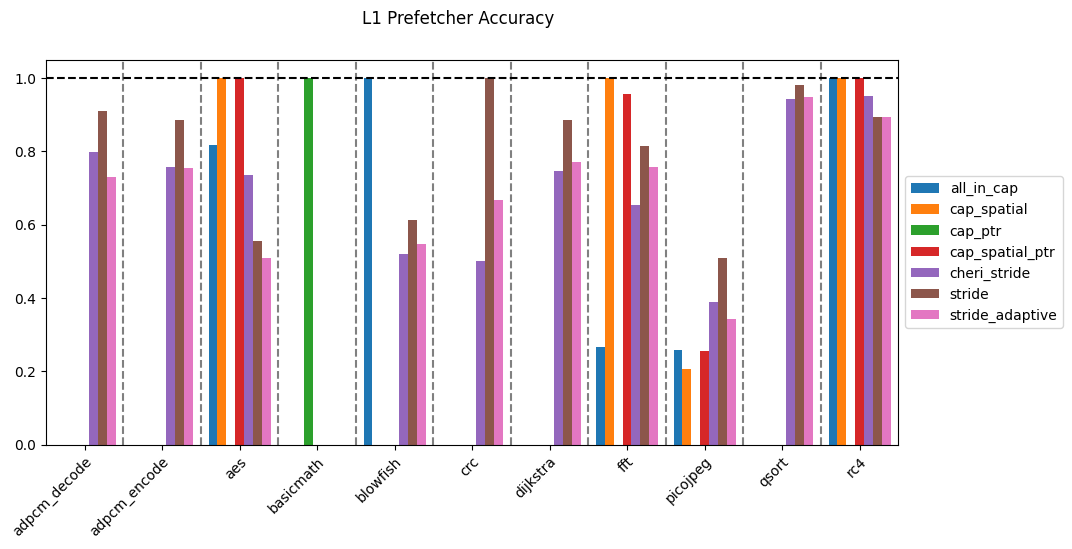

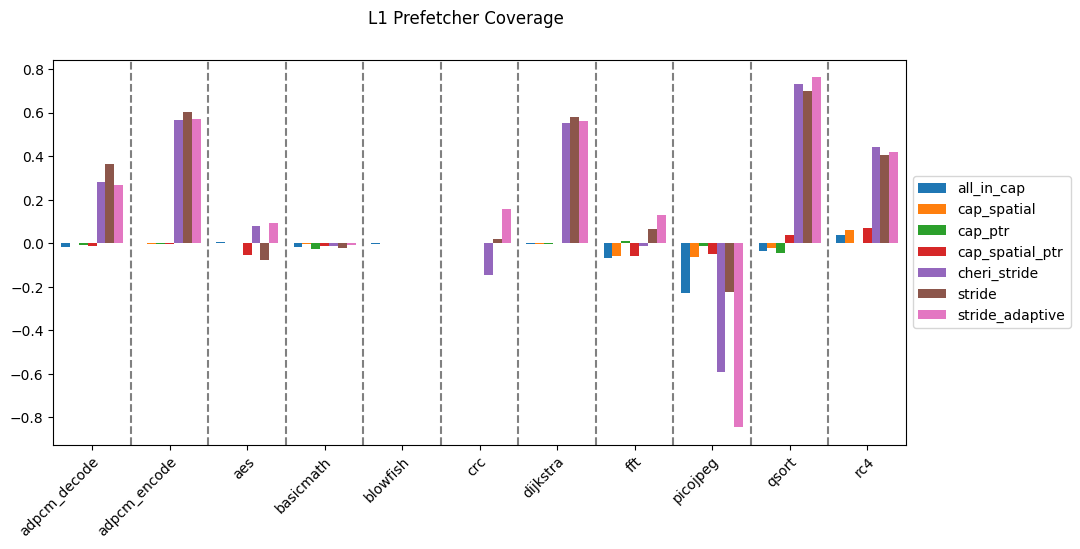

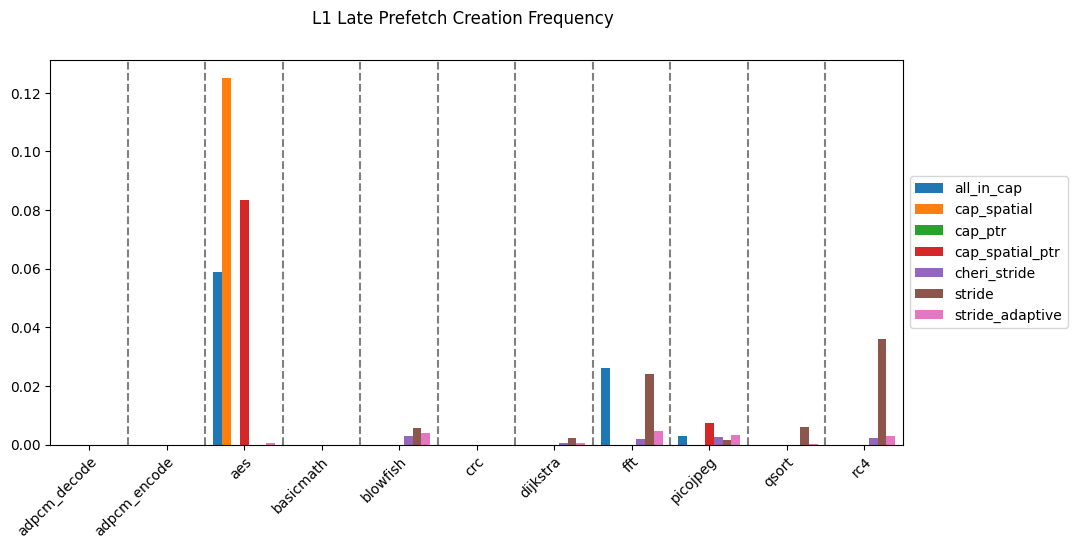

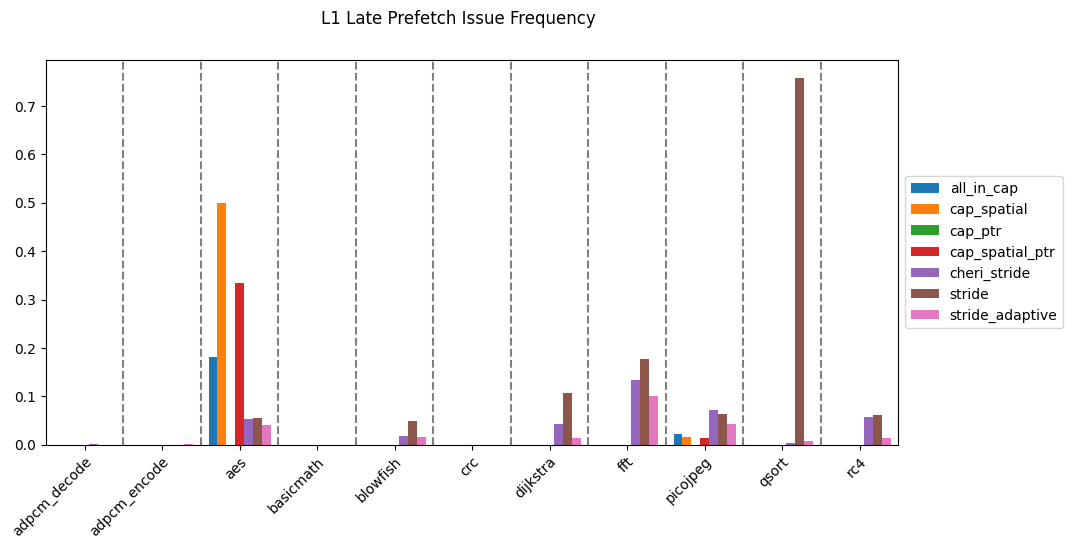

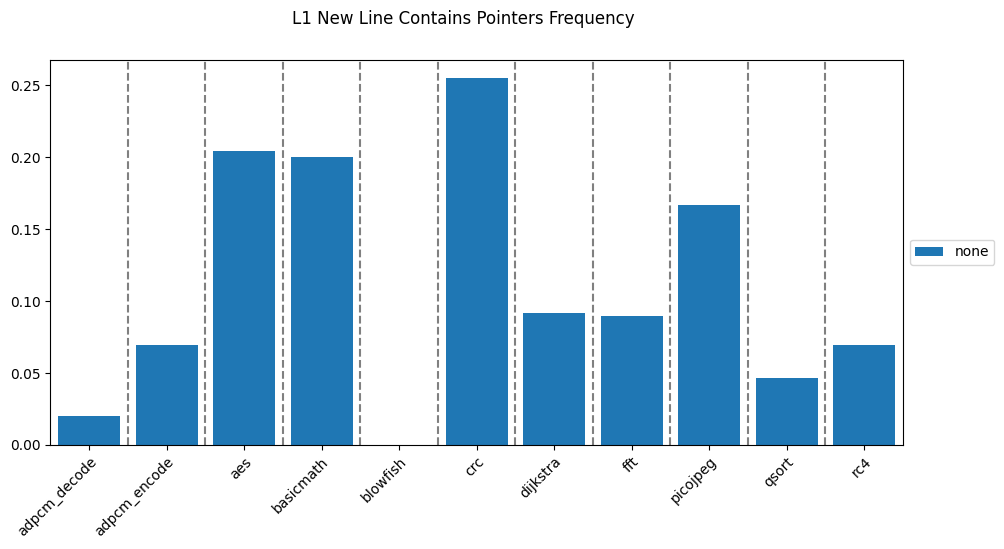

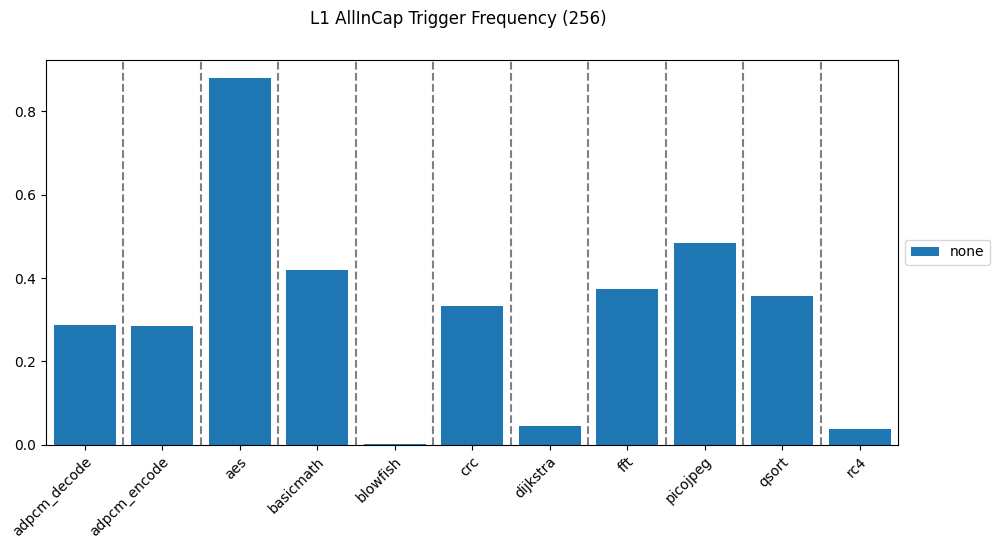

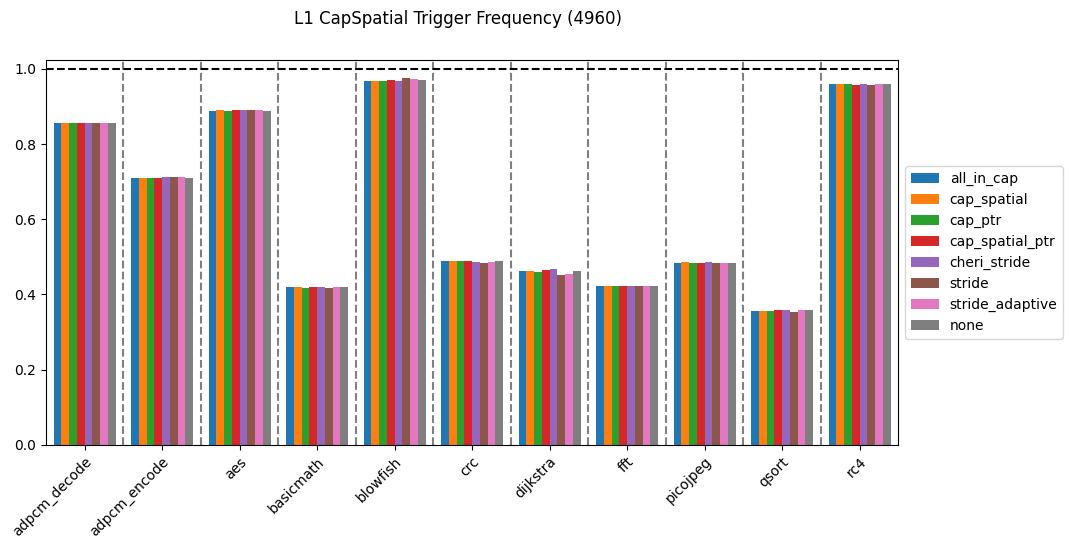

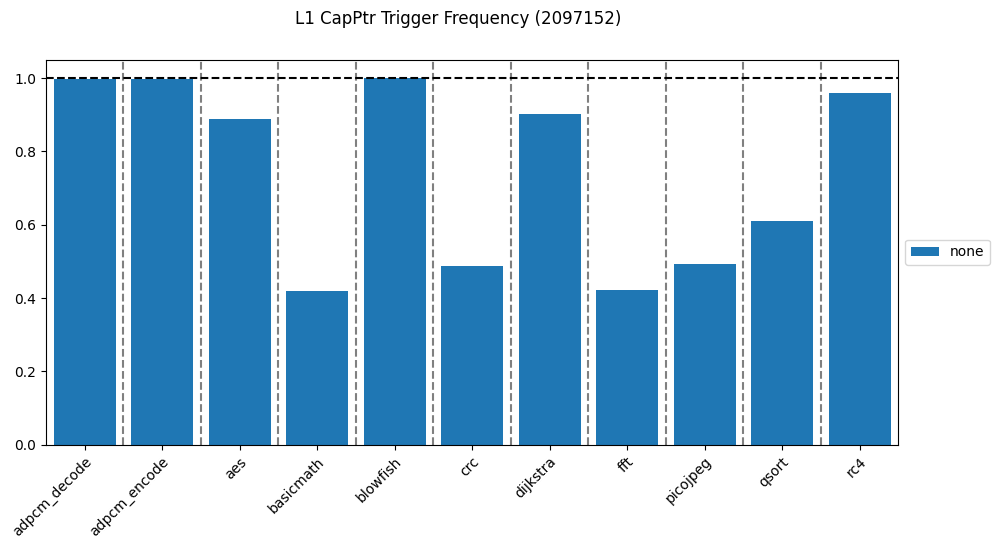

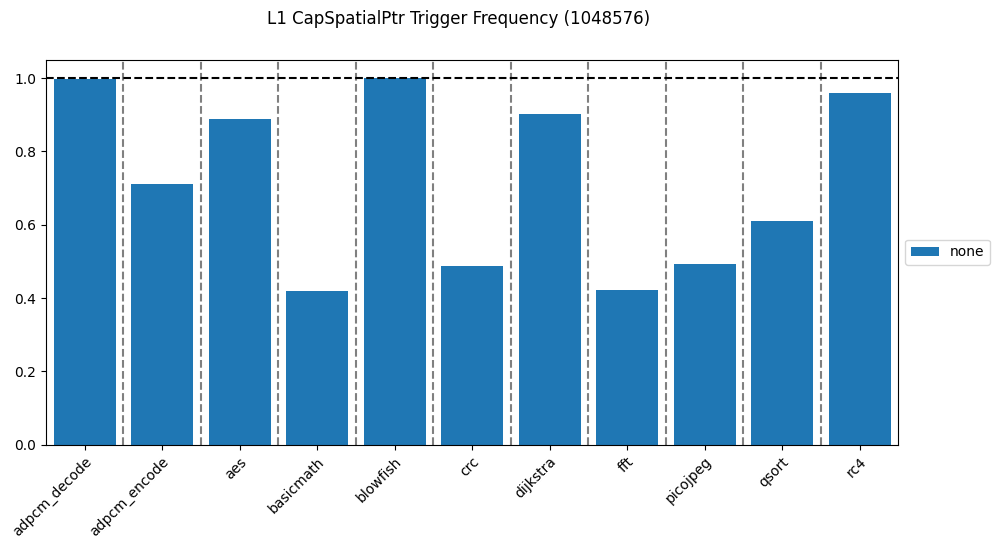

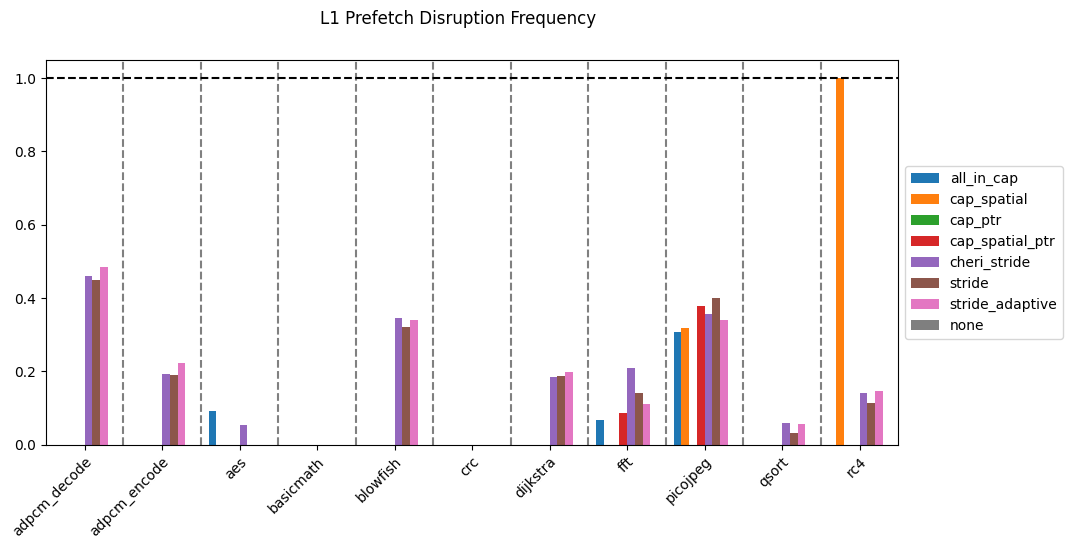

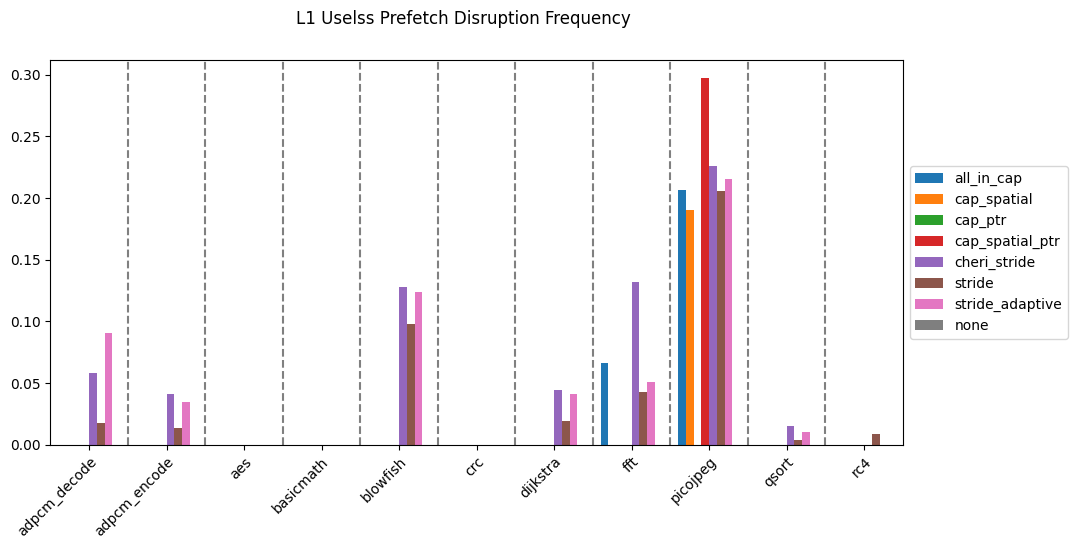

In [12]:
def groupedBarChart(
    data: dict[str, list],
    cats: list[str],
    figax=None
):
    fig, ax = figax if figax is not None else plt.subplots()
    nCats = len(cats)
    nGroups = len(data)
    assert(all(len(group) == nCats for group in data.values()))
     
    leqOne = True
    drawOne = False
    makeLog = False
    barWidth = 0.8 / nGroups
    xs = np.arange(nCats)
    for i, (groupName, groupData) in enumerate(data.items()):
        leqOne  = leqOne and all(d <= 1 for d in groupData)
        drawOne = drawOne or any(d >= 0.9 for d in groupData)
        makeLog = makeLog or any(d > 10000 for d in groupData)
        ax.bar(xs + barWidth * (i + 0.5 - nGroups/2), groupData, width=barWidth, label=groupName)

    for x in xs[1:]:
        ax.axvline(x - 0.5, color="grey", linestyle="--")
    if leqOne and drawOne:
        ax.axhline(1, color="black", linestyle="--")
    if makeLog:
        ax.set_yscale("log")
    ax.set_xticks(xs, cats)
    ax.set_xlim(-0.5, nCats-0.5)

    return fig, ax

for run, runStats in globalStats.items():
    for statName, prefetcherLocationStats in runStats.items():
        for location in LOCATIONS:
            locationData = {}
            if statName not in noPrefetcherRequiredForStat:
                locationData |= {p: s[location] for (p, s) in prefetcherLocationStats.items() if location in s}
            if not statName in noBaselineRequiredForStat:
                locationData |= {"none": prefetcherLocationStats["none"]["none"] }
            fig, ax = plt.subplots(figsize=(11,5))
            groupedBarChart(locationData, BENCHMARKS, figax=(fig, ax))
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
            fig.suptitle(f"{statName}")
            #fig.tight_layout()